# Chest X-ray Pneumonia Detection — Transfer Learning with PyTorch (ResNet18)

**Goal:** Fine-tune a pretrained ResNet18 on chest X-ray images to classify *PNEUMONIA* vs *NORMAL*.  
Includes training, validation, test evaluation, ROC/AUC, confusion matrix, and Grad-CAM visualizations.


#Install required packages


In [2]:
# NOTE: in some environments torch + torchvision should be installed separately following official instructions.
# If you already have torch and torchvision, you can comment out that line.
!pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu
!pip install -q kaggle scikit-learn matplotlib seaborn tqdm opencv-python


#Imports and device

In [3]:
import os
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models, datasets
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

import cv2
import json
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


 # Download dataset

In [4]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Set dataset path
# NOTE: Your folder has a space in its name, so keep it in quotes
data_dir = "/content/drive/MyDrive/xray dataset/chest_xray/chest_xray"

# Step 3: Clean unwanted MacOS files (.DS_Store etc.)
import os

for split in ["train", "test", "val"]:
    folder = os.path.join(data_dir, split)
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file == ".DS_Store":
                os.remove(os.path.join(root, file))

print("Subfolders in dataset:", os.listdir(data_dir))

# Step 4: Import PyTorch utilities
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Step 5: Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize all images
    transforms.ToTensor()           # convert to tensor
])

# Step 6: Load dataset
train_data = datasets.ImageFolder(root=data_dir + "/train", transform=transform)
test_data  = datasets.ImageFolder(root=data_dir + "/test", transform=transform)
val_data   = datasets.ImageFolder(root=data_dir + "/val", transform=transform)

# Step 7: Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)

# Step 8: Verify
print("Classes:", train_data.classes)
print("Train samples:", len(train_data))
print("Test samples:", len(test_data))
print("Val samples:", len(val_data))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Subfolders in dataset: ['.DS_Store', 'train', 'val', 'test']
Classes: ['NORMAL', 'PNEUMONIA']
Train samples: 5236
Test samples: 624
Val samples: 16


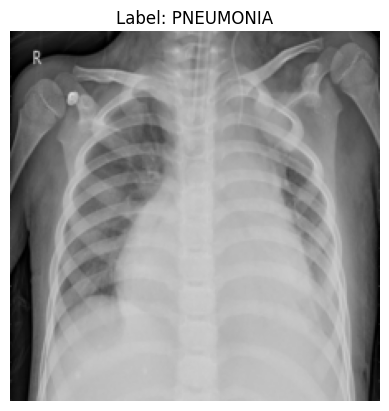

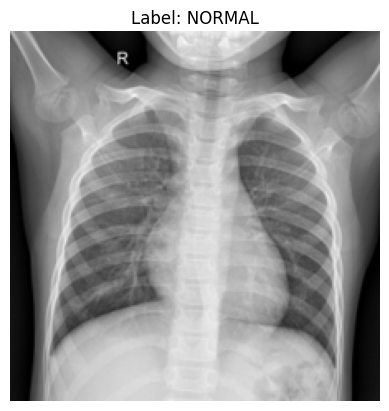

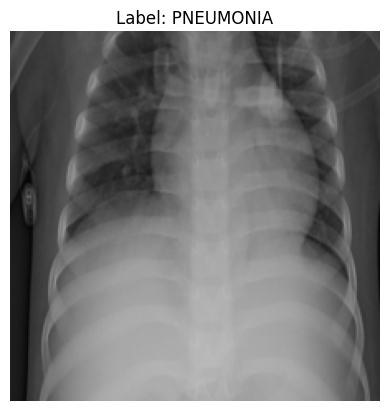

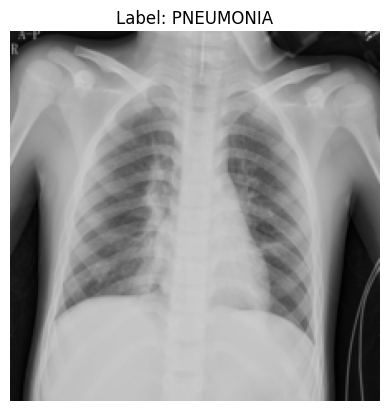

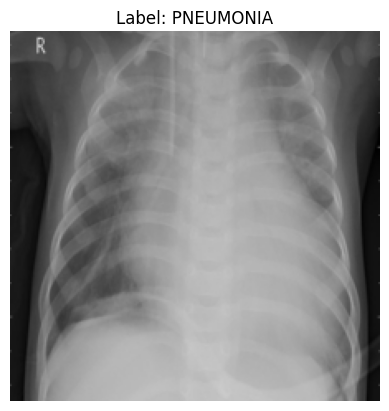

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, label):
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg, cmap="gray")
    plt.title(f"Label: {train_data.classes[label]}")
    plt.axis("off")
    plt.show()

# Get one batch from train loader
images, labels = next(iter(train_loader))

# Show first 5 images
for i in range(5):
    imshow(images[i], labels[i])


#Inspect dataset structure and counts

In [6]:
root = Path("/content/drive/MyDrive/xray dataset/chest_xray/chest_xray")
for split in ["train", "val", "test"]:
    split_dir = root / split
    if split_dir.exists():
        normal = len(list((split_dir/"NORMAL").glob("*.jpeg"))) + len(list((split_dir/"NORMAL").glob("*.jpg"))) + len(list((split_dir/"NORMAL").glob("*.png")))
        pneu = len(list((split_dir/"PNEUMONIA").glob("*.jpeg"))) + len(list((split_dir/"PNEUMONIA").glob("*.jpg"))) + len(list((split_dir/"PNEUMONIA").glob("*.png")))
        print(f"{split}: NORMAL={normal}, PNEUMONIA={pneu}")
    else:
        print(f"{split_dir} missing — please ensure dataset is extracted with expected folder structure.")


train: NORMAL=1341, PNEUMONIA=3895
val: NORMAL=8, PNEUMONIA=8
test: NORMAL=234, PNEUMONIA=390


#Transforms and ImageFolder datasets

In [7]:
# Cell 5 — Transforms and ImageFolder datasets
IMG_SIZE = 224  # ResNet default input size 224

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

train_dir = root / "train"
val_dir   = root / "val"
test_dir  = root / "test"

train_ds = datasets.ImageFolder(train_dir, transform=train_transform)
val_ds   = datasets.ImageFolder(val_dir, transform=val_transform)
test_ds  = datasets.ImageFolder(test_dir, transform=val_transform)

print("Classes:", train_ds.classes)
print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))
print("Test samples:", len(test_ds))


Classes: ['NORMAL', 'PNEUMONIA']
Train samples: 5236
Val samples: 16
Test samples: 624


#DataLoaders

In [8]:
# Cell 6 — DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 4 if os.name != 'nt' else 0

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


#Build the model (pretrained ResNet18) and modify the final layer

In [9]:
# Cell 7 — Build the model (pretrained ResNet18) and modify the final layer
model = models.resnet18(pretrained=True)

# Freeze earlier layers optionally (here we fine-tune last block + fc)
for name, param in model.named_parameters():
    param.requires_grad = False

# Unfreeze layer4 and fc for fine­tuning
for name, param in model.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        param.requires_grad = True

# Replace final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # binary classification: NORMAL vs PNEUMONIA
model = model.to(device)
print(model)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Loss, optimizer, scheduler

In [10]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

# Only parameters with requires_grad=True will be optimized
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',   # or 'min' if monitoring loss
    factor=0.5,
    patience=2
)


# Training & validation loop with checkpointing (best val ROC-AUC)

In [11]:
# Cell 9 — Training & validation loop with checkpointing (best val ROC-AUC)
import time
best_auc = 0.0
EPOCHS = 8
save_path = "best_resnet18_chestxray.pth"

history = {"train_loss":[], "val_loss":[], "val_auc":[]}

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_probs = []
    all_targets = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            probs = torch.softmax(outputs, dim=1)[:,1].cpu().numpy()
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_probs.extend(probs.tolist())
            all_preds.extend(preds.tolist())
            all_targets.extend(labels.cpu().numpy().tolist())
    epoch_val_loss = val_loss / len(val_loader.dataset)
    try:
        epoch_val_auc = roc_auc_score(all_targets, all_probs)
    except:
        epoch_val_auc = 0.0

    print(f"Epoch {epoch} Train Loss: {epoch_train_loss:.4f}  Val Loss: {epoch_val_loss:.4f}  Val AUC: {epoch_val_auc:.4f}")
    history["train_loss"].append(epoch_train_loss)
    history["val_loss"].append(epoch_val_loss)
    history["val_auc"].append(epoch_val_auc)

    # Scheduler step on val AUC
    scheduler.step(epoch_val_auc)

    # Checkpoint best model
    if epoch_val_auc > best_auc:
        best_auc = epoch_val_auc
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_auc": best_auc
        }, save_path)
        print(f"Saved best model with val AUC: {best_auc:.4f}")


Epoch 1 [Train]:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 1 Train Loss: 0.1327  Val Loss: 0.3714  Val AUC: 0.9688
Saved best model with val AUC: 0.9688


Epoch 2 [Train]:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 2 Train Loss: 0.0769  Val Loss: 0.3073  Val AUC: 1.0000
Saved best model with val AUC: 1.0000


Epoch 3 [Train]:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 3 Train Loss: 0.0537  Val Loss: 0.3660  Val AUC: 1.0000


Epoch 4 [Train]:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 4 Train Loss: 0.0384  Val Loss: 0.3497  Val AUC: 1.0000


Epoch 5 [Train]:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 5 Train Loss: 0.0315  Val Loss: 0.5884  Val AUC: 1.0000


Epoch 6 [Train]:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 6 Train Loss: 0.0242  Val Loss: 0.2289  Val AUC: 1.0000


Epoch 7 [Train]:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.0239  Val Loss: 0.4531  Val AUC: 1.0000


Epoch 8 [Train]:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 8 Train Loss: 0.0158  Val Loss: 0.5700  Val AUC: 1.0000


# Plot training curves

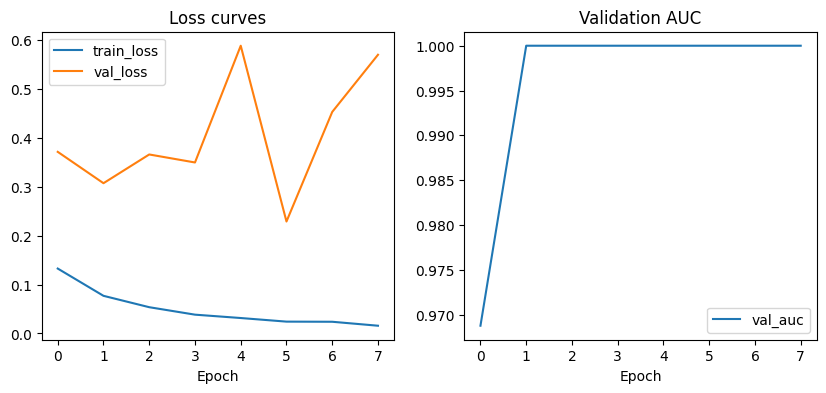

In [12]:
# Cell 10 — Plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.legend(); plt.title("Loss curves")

plt.subplot(1,2,2)
plt.plot(history["val_auc"], label="val_auc")
plt.xlabel("Epoch"); plt.legend(); plt.title("Validation AUC")
plt.show()


#  Load best model checkpoint for test evaluation

In [13]:
checkpoint = torch.load(save_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
print("Loaded best model from epoch", checkpoint["epoch"], "with val AUC", checkpoint["val_auc"])


Loaded best model from epoch 2 with val AUC 1.0


In [14]:
import random
import torch
from torchvision import transforms
from PIL import Image
from pathlib import Path

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained model
checkpoint = torch.load("/content/best_resnet18_chestxray.pth", map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

# Preprocessing (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Test dataset path
test_dir = Path("/content/drive/MyDrive/xray dataset/chest_xray/chest_xray/test")

# Collect all image paths
all_images = list(test_dir.rglob("*.jpeg")) + list(test_dir.rglob("*.jpg")) + list(test_dir.rglob("*.png"))

# Pick 5 random images
sample_images = random.sample(all_images, 5)

# Prediction loop
classes = ["NORMAL", "PNEUMONIA"]
for img_path in sample_images:
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img_tensor).argmax(1).item()

    print(f"🩻 {img_path.name} → Predicted: **{classes[pred]}**")


🩻 NORMAL2-IM-0098-0001.jpeg → Predicted: **NORMAL**
🩻 person133_bacteria_638.jpeg → Predicted: **PNEUMONIA**
🩻 person108_bacteria_504.jpeg → Predicted: **PNEUMONIA**
🩻 person33_virus_72.jpeg → Predicted: **PNEUMONIA**
🩻 person91_bacteria_446.jpeg → Predicted: **PNEUMONIA**
